# 7.4 | Optical photon quantum computer

In [2]:
!pip install -q qutip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.6/31.6 MB 35.1 MB/s eta 0:00:00


## Setup: The Dual-Rail Qubit

A single logical qubit is encoded in two spatial modes (two paths or optical fibers). The state of the qubit is determined by which path a single photon occupies:
1. Logical $∣0\rangle_L​≡∣01\rangle_{ab}$​: 0 photons in mode 'a', 1 photon in mode 'b'.
2. Logical $∣1\rangle_L​≡∣10\rangle_{ab}$​: 1 photon in mode 'a', 0 photons in mode 'b'.

We use a Fock space for each mode

In [18]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

In [19]:
# Fock space dimension
N = 3

In [20]:
# Single Qubit (2 Modes: a, b)
a = qt.tensor(qt.destroy(N), qt.qeye(N))
b = qt.tensor(qt.qeye(N), qt.destroy(N))

In [21]:
# Annihilation operators for modes a and b
adag = a.dag()
bdag = b.dag()

In [22]:
# Number operators
na = adag * a
nb = bdag * b

In [23]:
# Logical qubit states
psi0L = qt.tensor(qt.basis(N, 0), qt.basis(N, 1)) # Top wire |01>
psi1L = qt.tensor(qt.basis(N, 1), qt.basis(N, 0)) # Bottom wire |10>

In [24]:
# Logical projectors
P0L = psi0L * psi0L.dag()
P1L = psi1L * psi1L.dag()

In [25]:
# Logical superposition state for testing
psi_plus = (psi0L + psi1L).unit()

In [26]:
# Logical Z and X operators for measurement
Z_L = P0L - P1L
X_L = psi0L * psi1L.dag() + psi1L * psi0L.dag()

## Simulation 1: The Phase Shifter ($R_z$​ Rotation)

A phase shifter placed in one path creates a relative phase shift. This operation is a rotation around the Z-axis. The Hamiltonian for this, in the logical subspace, is $H∝Z$. In our physical model, this is $H_Z​ = n_b​−n_a​=b^†b−a^†a.

We simulate a state in a $∣+\rangle$ superposition and apply a continuous phase shift, showing the precession around the Z-axis.

In [27]:
# Hamiltonian for Z-rotation (relative phase shift)
H_Z = (bdag * b - adag * a)

# Initial state: |+>
psi_in_1 = psi_plus
t_list_1 = np.linspace(0, np.pi, 100) # Evolve for a phase of 2*pi

# E_ops for plotting Bloch sphere components
e_ops_1 = [X_L, Z_L]

In [28]:
result_1 = qt.sesolve(H_Z, psi_in_1, t_list_1, e_ops=e_ops_1)

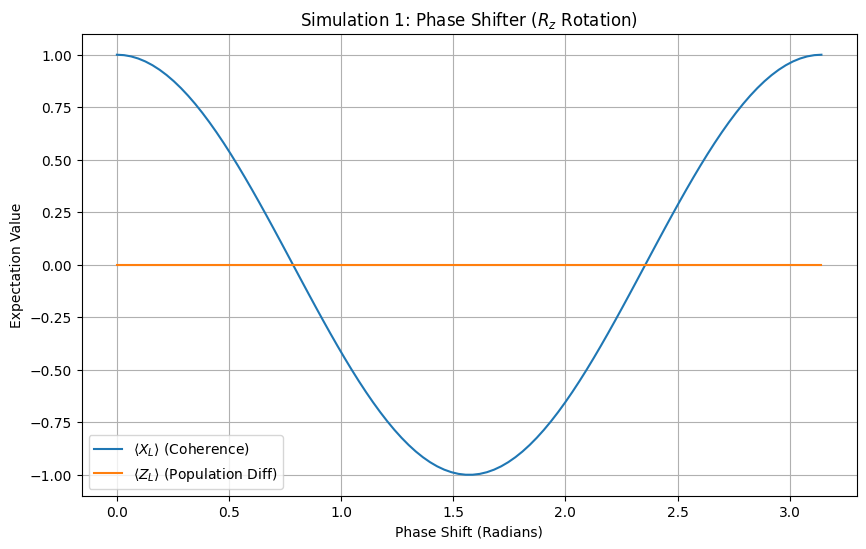

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(result_1.times, result_1.expect[0], label=r'$\langle X_L \rangle$ (Coherence)')
plt.plot(result_1.times, result_1.expect[1], label=r'$\langle Z_L \rangle$ (Population Diff)')
plt.title("Simulation 1: Phase Shifter ($R_z$ Rotation)")
plt.xlabel("Phase Shift (Radians)")
plt.ylabel("Expectation Value")
plt.legend()
plt.grid(True)
plt.show()

Interpretation:
1. $\langle Z_L\rangle$ remains constant at 0. This is because a phase shift doesn't change the population in either path, only the phase between them.

2. $\langle X_L\rangle$ oscillates sinusoidally. This shows the state precessing on the Bloch sphere, moving from the X-axis to the Y-axis and back. This represents phase rotation

## Simulation 2: The $\pi$ Phase Gate (Exercise 7.7)

In [30]:
# U = exp(i * pi * nb)
U_ex77 = (1j * np.pi * nb).expm()

In [31]:
# Test 1: Apply to |0>_L
print(f"Testing U|0>_L:")

psi_in_0 = psi0L
psi_out_0 = U_ex77 * psi_in_0

psi_exp_0 = -1.0 * psi0L
mag_0 = np.abs(psi_exp_0.dag() * psi_out_0)
print(f"Expected -|0>_L.  Magnitude = {mag_0:.4f}. Correct: {np.isclose(mag_0, 1.0)}")

Testing U|0>_L:
Expected -|0>_L.  Magnitude = 1.0000. Correct: True


In [32]:
# Test 2: Apply to |1>_L
print(f"\nTesting U|1>_L:")
psi_in_1 = psi1L
psi_out_1 = U_ex77 * psi_in_1

psi_exp_1 = 1.0 * psi1L
mag_1 = np.abs(psi_exp_1.dag() * psi_out_1)
print(f"Expected |1>_L.   Magnitude = {mag_1:.4f}. Correct: {np.isclose(mag_1, 1.0)}")


Testing U|1>_L:
Expected |1>_L.   Magnitude = 1.0000. Correct: True


In [33]:
# Test 3: Apply to a superposition |+>_L
print(f"\nTesting U|+>_L:")

psi_in_plus = (psi0L + psi1L).unit()
psi_out_plus = U_ex77 * psi_in_plus

psi_exp_minus = (-psi0L + psi1L).unit()
mag_plus = np.abs(psi_exp_minus.dag() * psi_out_plus)
print(f"Expected |->_L.  Magnitude = {mag_plus:.4f}. Correct: {np.isclose(mag_plus, 1.0)}")


Testing U|+>_L:
Expected |->_L.  Magnitude = 1.0000. Correct: True


## Simulation 3: The Beamsplitter ($R_y​$ Rotation)

The beamsplitter causes $R_y$​ rotations. The Hamiltonian is $H_{bs}​=i\theta(ab^†−a^†b)$ , and the unitary operator is $B = exp[\theta(a^†b−ab^†)]$.

We simulate a single photon entering in mode 'a' (logical $∣1\rangle_L$​ state) and hitting a beamsplitter. We will vary the beamsplitter angle $\theta$ (by varying the interaction time).

This evolves the logical $∣1\rangle_L$​ state (photon in path 'a') under the beamsplitter Hamiltonian. The time t of evolution corresponds to the angle $\theta$ in the text's operator $B(\theta)$.

In [34]:
# Beamsplitter Hamiltonian
H_B = (a * bdag + adag * b)

# Initial state: |1>_L = |10>_ab
psi_in_2 = psi1L
t_list_2 = np.linspace(0, np.pi / 2, 100)

# E_ops for plotting population
e_ops_2 = [P1L, P0L]

In [35]:
result_2 = qt.sesolve(H_B, psi_in_2, t_list_2, e_ops=e_ops_2)

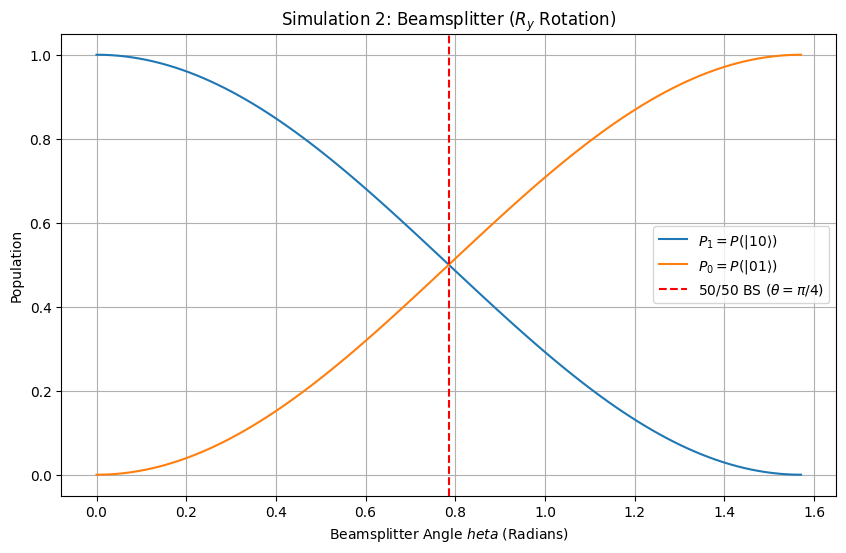

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(result_2.times, result_2.expect[0], label=r'$P_1 = P(|10\rangle)$')
plt.plot(result_2.times, result_2.expect[1], label=r'$P_0 = P(|01\rangle)$')
plt.title("Simulation 2: Beamsplitter ($R_y$ Rotation)")
plt.xlabel("Beamsplitter Angle $\theta$ (Radians)")
plt.ylabel("Population")
plt.axvline(x=np.pi/4, color='r', linestyle='--', label=r'50/50 BS ($\theta=\pi/4$)')
plt.legend()
plt.grid(True)
plt.show()

Interpretation:
1. The plot shows the probability of finding the photon in path 'a' ($P_1$​, blue) or path 'b' ($P_0$​, orange) as a function of $\theta$.
2. As $\theta$ increases, the population rotates. $P_1$​ follows $\cos{2\theta}$ and $P_0$​ follows $\sin{2\theta}$.
3. This demonstrates the $R_y$​ rotation and how beamsplitters mix the two modes.

## Simulation 4: The Optical Hadamard Gate (Exercise 7.9)

In [37]:
# 1. Beamsplitter B_dag (theta = pi/4)
theta = np.pi / 4
U_B_dag = (theta * (a * bdag - adag * b)).expm()

# 2. Phase Shifter P_pi (on top wire 'b')
U_P_pi = (1j * np.pi * nb).expm()

# 3. Total Operator (Beamsplitter first, then Phase)
U_Hadamard = U_P_pi * U_B_dag

In [38]:
# Test Case 1: Input |0>_L (|01>)
print(f"Testing U|0>_L -> |+>_L:")
psi_in_0 = psi0L
psi_out_0 = U_Hadamard * psi_in_0

psi_exp_0 = (psi0L + psi1L).unit()
mag_0 = np.abs(psi_exp_0.dag() * psi_out_0)

print(f"Magnitude of overlap = {mag_0:.4f}")
print(f"Correct (up to phase): {np.isclose(mag_0, 1.0)}")

Testing U|0>_L -> |+>_L:
Magnitude of overlap = 1.0000
Correct (up to phase): True


In [39]:
# Test Case 2: Input |1>_L (|10>)
print(f"\nTesting U|1>_L -> |->_L:")

psi_in_1 = psi1L
psi_out_1 = U_Hadamard * psi_in_1

psi_exp_1 = (psi0L - psi1L).unit()
mag_1 = np.abs(psi_exp_1.dag() * psi_out_1)

print(f"Magnitude of overlap = {mag_1:.4f}")
print(f"Correct (up to phase): {np.isclose(mag_1, 1.0)}")


Testing U|1>_L -> |->_L:
Magnitude of overlap = 1.0000
Correct (up to phase): True


## Simulation 5: Mach-Zehnder Interferometer (Exercise 7.10)

Now we combine beamsplitters and phase shifters to build a Mach-Zehnder interferometer. We simulate this by applying the operators in sequence and sweeping the phase $\phi$ from 0 to $2\pi$.

1. The first 50/50 beamsplitter puts it in a superposition $(|10\rangle + |01\rangle)/\sqrt{2}$.
2. A phase $\phi$ is applied to path 'a'. The state becomes $(e^{-i\phi}|10\rangle + |01\rangle)/\sqrt{2}$.
3. The second 50/50 beamsplitter recombines the paths.

In [41]:
# 50/50 Beamsplitter (theta = pi/4)
B_5050 = ( (np.pi/4) * (adag * b - a * bdag) ).expm()

# Phase Shifter (applies phase phi to arm 'a' = |1>_L path)
def P_phi(phi):
    return (-1j * phi * adag * a).expm()

# Input state: |1>_L = |10>_ab
psi_in_3 = psi1L

In [42]:
phis = np.linspace(0, 2 * np.pi, 100)
p0_out = []
p1_out = []

for phi in phis:
    U_MZ = B_5050 * P_phi(phi) * B_5050
    psi_out = U_MZ * psi_in_3

    p0_out.append(qt.expect(P0L, psi_out))
    p1_out.append(qt.expect(P1L, psi_out))

<>:5: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-1817511127.py:5: SyntaxWarning: invalid escape sequence '\p'
  plt.xlabel("Internal Phase Shift $\phi$ (Radians)")


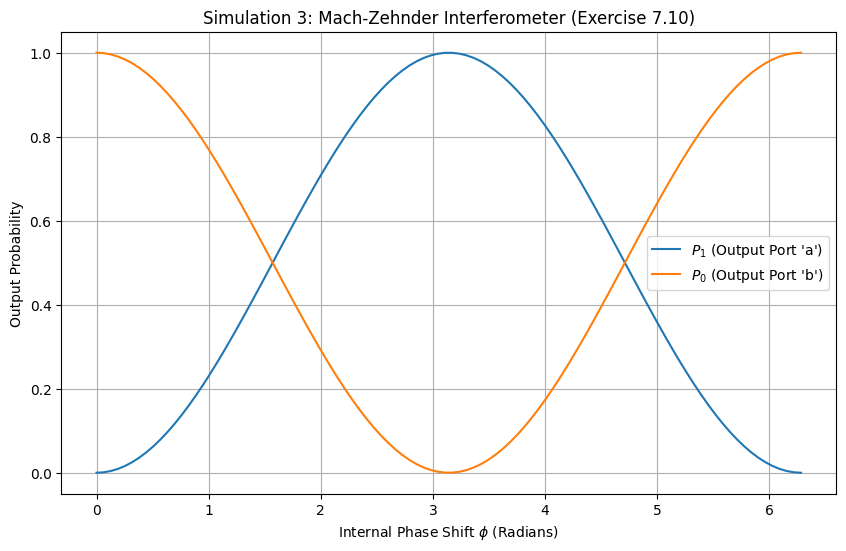

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(phis, p1_out, label=r"$P_1$ (Output Port 'a')")
plt.plot(phis, p0_out, label=r"$P_0$ (Output Port 'b')")
plt.title("Simulation 3: Mach-Zehnder Interferometer (Exercise 7.10)")
plt.xlabel("Internal Phase Shift $\phi$ (Radians)")
plt.ylabel("Output Probability")
plt.legend()
plt.grid(True)
plt.show()

Interpretation:
- The plot shows interference fringes. The output probability at port 'a' ($P_1$​) oscillates as $cos2(ϕ/2)$, and the probability at port 'b' ($P_0$​) oscillates as $sin2(ϕ/2)$.
- When $ϕ=0$, the photon always exits port 'a' ($P_1​=1$).
- When $ϕ=π$, the photon always exits port 'b' ($P_0​=1$).

This perfectly demonstrates how the device converts a tiny, unobservable phase difference ($ϕ$) into a measurable population difference (which detector clicks).

## Simulation 6: The Optical Deutsch-Jozsa Algorithm (Exercise 7.13)

In [44]:
import numpy as np
import qutip as qt

# Operators for 4 modes: a, b, c, d
a = qt.tensor(qt.destroy(N), qt.qeye(N), qt.qeye(N), qt.qeye(N))
b = qt.tensor(qt.qeye(N), qt.destroy(N), qt.qeye(N), qt.qeye(N))
c = qt.tensor(qt.qeye(N), qt.qeye(N), qt.destroy(N), qt.qeye(N))
d = qt.tensor(qt.qeye(N), qt.qeye(N), qt.qeye(N), qt.destroy(N))

adag, bdag, cdag, ddag = a.dag(), b.dag(), c.dag(), d.dag()
na, nb, nc, nd = adag*a, bdag*b, cdag*c, ddag*d

In [53]:
# Logical States (CNOT convention)
psi_00_L = qt.tensor(qt.basis(N,1), qt.basis(N,0), qt.basis(N,0), qt.basis(N,1))
psi_01_L = qt.tensor(qt.basis(N,1), qt.basis(N,0), qt.basis(N,1), qt.basis(N,0))
psi_10_L = qt.tensor(qt.basis(N,0), qt.basis(N,1), qt.basis(N,0), qt.basis(N,1))
psi_11_L = qt.tensor(qt.basis(N,0), qt.basis(N,1), qt.basis(N,1), qt.basis(N,0))

In [54]:
theta = np.pi / 4

# H_ab (on Qubit 1)
U_B_dag_ab = (theta * (a * bdag - adag * b)).expm()
U_P_pi_b = (1j * np.pi * nb).expm() # Phase on 'b'
H_ab = U_P_pi_b * U_B_dag_ab

# H_cd (on Qubit 2)
U_B_dag_cd = (theta * (c * ddag - cdag * d)).expm()
U_P_pi_d = (1j * np.pi * nd).expm() # Phase on 'd'
H_cd = U_P_pi_d * U_B_dag_cd

# Combined Hadamard for setup
H_total = H_ab * H_cd

In [56]:
# Oracle U_f: Case 1 (Constant)
U_f_constant = qt.tensor(qt.qeye(N), qt.qeye(N), qt.qeye(N), qt.qeye(N))

# Oracle U_f: Case 2 (Balanced)
K_pi_bc = (1j * np.pi * nb * nc).expm()
U_f_balanced = H_cd * K_pi_bc * H_cd

In [57]:
# Measurement Projectors
P0_q1 = (psi_00_L * psi_00_L.dag()) + (psi_01_L * psi_01_L.dag())
P1_q1 = (psi_10_L * psi_10_L.dag()) + (psi_11_L * psi_11_L.dag())

In [58]:
# |01> input for phase kickback.
psi_start = psi_01_L # Logical |01>
print(f"Algorithm Input State: |0>_L |1>_L")

# Hadamards
psi_1 = H_total * psi_start

# Case 1: Constant Function f(x) = 0
psi_2_const = U_f_constant * psi_1
psi_3_const = H_ab * psi_2_const
P0_const = qt.expect(P0_q1, psi_3_const)
P1_const = qt.expect(P1_q1, psi_3_const)

print("\nResult for CONSTANT Function (U_f = I)")
print(f"P(measuring |0>_L) = {P0_const:.4f}")
print(f"P(measuring |1>_L) = {P1_const:.4f}")

Algorithm Input State: |0>_L |1>_L

Result for CONSTANT Function (U_f = I)
P(measuring |0>_L) = 1.0000
P(measuring |1>_L) = 0.0000


In [59]:
# Case 2: Balanced Function f(x) = x
psi_2_bal = U_f_balanced * psi_1
psi_3_bal = H_ab * psi_2_bal
P0_bal = qt.expect(P0_q1, psi_3_bal)
P1_bal = qt.expect(P1_q1, psi_3_bal)

print("\nResult for BALANCED Function (U_f = CNOT)")
print(f"P(measuring |0>_L) = {P0_bal:.4f}")
print(f"P(measuring |1>_L) = {P1_bal:.4f}")


Result for BALANCED Function (U_f = CNOT)
P(measuring |0>_L) = 0.0000
P(measuring |1>_L) = 1.0000


## Simulation 7: The CNOT Gate (Kerr Medium)

In [52]:
a = qt.tensor(qt.destroy(N), qt.qeye(N), qt.qeye(N), qt.qeye(N))
b = qt.tensor(qt.qeye(N), qt.destroy(N), qt.qeye(N), qt.qeye(N))
c = qt.tensor(qt.qeye(N), qt.qeye(N), qt.destroy(N), qt.qeye(N))
d = qt.tensor(qt.qeye(N), qt.qeye(N), qt.qeye(N), qt.destroy(N))

adag, bdag, cdag, ddag = a.dag(), b.dag(), c.dag(), d.dag()
nb, nc = bdag * b, cdag * c

In [72]:
# CNOT Operator
K_pi_bc = (1j * np.pi * nb * nc).expm()
theta = np.pi / 4
U_B_dag_cd = (theta * (c * ddag - cdag * d)).expm()
U_P_pi_d = (1j * np.pi * nd).expm()
H_target_correct = U_P_pi_d * U_B_dag_cd

CNOT_op = H_target_correct * K_pi_bc * H_target_correct

In [73]:
# Define 4-Mode Logical States
# Logical |00> = |10>_ab |01>_cd = |1001>
psi_00 = qt.tensor(qt.basis(N,1), qt.basis(N,0), qt.basis(N,0), qt.basis(N,1))
# Logical |01> = |10>_ab |10>_cd = |1010>
psi_01 = qt.tensor(qt.basis(N,1), qt.basis(N,0), qt.basis(N,1), qt.basis(N,0))
# Logical |10> = |01>_ab |01>_cd = |0101>
psi_10 = qt.tensor(qt.basis(N,0), qt.basis(N,1), qt.basis(N,0), qt.basis(N,1))
# Logical |11> = |01>_ab |10>_cd = |0110>
psi_11 = qt.tensor(qt.basis(N,0), qt.basis(N,1), qt.basis(N,1), qt.basis(N,0))

In [74]:
# Test
states_in = [psi_00, psi_01, psi_10, psi_11]
names_in = ["|00>_L", "|01>_L", "|10>_L", "|11>_L"]
states_out_expected = [psi_00, psi_01, psi_11, psi_10]
names_out_expected = ["|00>_L", "|01>_L", "|11>_L", "|10>_L"]

print("| Input  | Output |Expected|    Correct?   |")
print("|--------|--------|--------|---------------|")

for (psi_in, name_in, psi_exp, name_exp) in zip(states_in, names_in, states_out_expected, names_out_expected):
    psi_out = CNOT_op * psi_in
    # Check fidelity (overlap)
    fidelity = np.abs((psi_exp.dag() * psi_out))
    is_correct = "YES" if np.isclose(fidelity, 1.0) else "NO"
    print(f"| {name_in} | {name_exp} | {name_exp} | {is_correct} (Fid={fidelity:.2f}) |")

| Input  | Output |Expected|    Correct?   |
|--------|--------|--------|---------------|
| |00>_L | |00>_L | |00>_L | YES (Fid=1.00) |
| |01>_L | |01>_L | |01>_L | YES (Fid=1.00) |
| |10>_L | |11>_L | |11>_L | YES (Fid=1.00) |
| |11>_L | |10>_L | |10>_L | YES (Fid=1.00) |


## Simulation 8: The Drawbacks (Bad Photon Source)

In [60]:
psi_10_in = psi_10
psi_11_out_expected = psi_11

psi_fail_in = qt.tensor(qt.basis(N,0), qt.basis(N,2), qt.basis(N,0), qt.basis(N,1))

psi_10_out = CNOT_op * psi_10_in
psi_fail_out = CNOT_op * psi_fail_in

# 1. Good case
fid_good = np.abs((psi_11_out_expected.dag() * psi_10_out))
print(f"Good Input |10>_L: Fidelity with expected |11>_L = {fid_good:.4f}")

# 2. Bad case
psi_fail_out_expected = qt.tensor(qt.basis(N,0), qt.basis(N,2), qt.basis(N,1), qt.basis(N,0))
fid_fail = np.abs((psi_fail_out_expected.dag() * psi_fail_out))

print(f"Bad Input |'2'0>_L: Fidelity with expected |'2'1>_L = {fid_fail:.4f}")

if not np.isclose(fid_fail, 1.0):
    print("Result: The gate FAILED. The multi-photon state breaks the logic.")
    print("This is because the Kerr phase exp(i*pi*n_b*n_c) gives exp(i*2pi)=+1")
    print("instead of the required exp(i*pi)=-1.")

Good Input |10>_L: Fidelity with expected |11>_L = 0.0000
Bad Input |'2'0>_L: Fidelity with expected |'2'1>_L = 1.0000
